### Approximate any 1D input-output function with the rank-2 excitatory-inhibitory network

In this notebook, we will do the following:
- Generate a random, smooth 1D function using a Gaussian Process
- Construct a continuous, piecewise-linear approximation to this function
- Decompose the piecewise-linear function into the difference of two convex functions
- Map the two convex functions onto excitatory and inhibitory spike-threshold boundaries
- Simulate the equivalent spiking network, showing that the output approximates the original function

This notebook accompanies the paper [Podlaski & Machens (2024). Neural Computation 36.5 803-857.](https://direct.mit.edu/neco/article/36/5/803/120324/Approximating-Nonlinear-Functions-With-Latent)



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp2d
import seaborn as sns

from helper_fcns import *
import sys
sys.path.append('../')
sys.path.append('../figure_generation_code/')
import plot_utils as pu
import net_sim_code as scnf

#### Step 1: Generate a random smooth function

In [2]:
# generate random function
xlims = [0, 10]
x, y = generate_random_smooth_function(l=1, sig=0.5, sig_n=1, xlims=xlims, seed=51)  # change seed to generate a different fcn


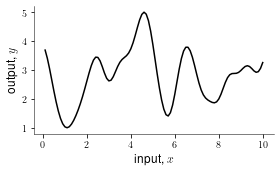

In [3]:
# plot the function
f, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(x, y, color='black')
ax.set_xlabel(r'input, $x$', fontsize=12)
ax.set_ylabel(r'output, $y$', fontsize=12)
sns.despine()
f.tight_layout()

#### Step 2: Construct a piecewise linear approximation to this function

There are many ways to do this --- here I identify the maxima and minima of the second derivative of the function
and use these points as the inflection points of the piecewise linear function.

In [4]:
# Here I will numerically find the first three derivatives of y, and use the roots of the third derivative to find the inflection points 

# x sample rate
d_x = x[1]-x[0]  # dx

# x needs to be resampled for each derivative
dx = diff_x(x)
ddx = diff_x(dx)
dddx = diff_x(ddx)

# Numerically compute the derivatives
B = y  # the function y, which will be the desired boundary, B
G = (1./d_x)*np.diff(B)  # first derivative (or gradient) of y
C = (1./d_x)*np.diff(G)  # second derivative (or curvature) of y
dC = (1./d_x)*np.diff(C)  # third derivative (or derivative of curvature) of y

# find the inflection points of the piecewise-linear function
x_roots, idx_roots = find_numerical_roots(dddx,dC)
x_roots = np.array([xlims[0]] + x_roots + [xlims[1]])

# construct a piecewise linear function with these points
x_roots, B_roots, B_pw = get_piecewise_fcn(x, B, x_roots)

# Recompute all of the derivatives of the piecewise linear function for comparison
G_pw = (1./d_x)*np.diff(B_pw)
C_pw = (1./d_x)*np.diff(G_pw)
dC_pw = (1./d_x)*np.diff(C_pw)


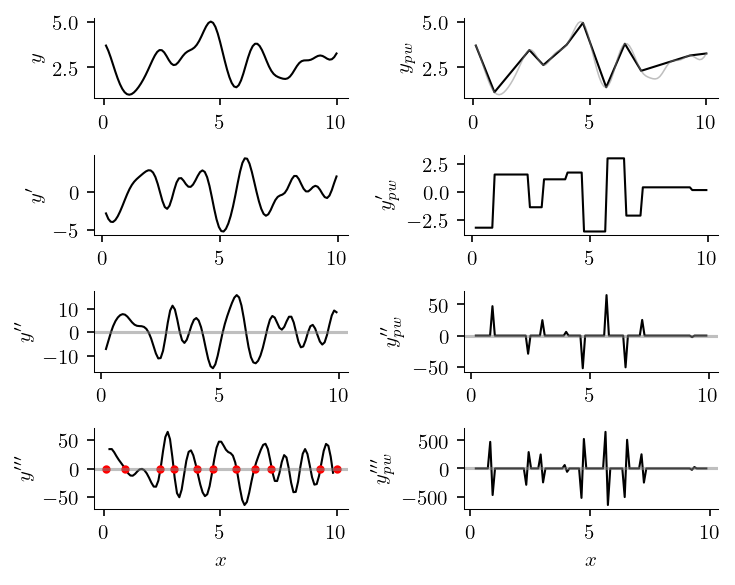

In [5]:
# plot the results
f = plt.figure(figsize=(5,4),dpi=150)
gs = f.add_gridspec(4, 2)
ax1a = f.add_subplot(gs[0, 0])
ax2a = f.add_subplot(gs[1, 0])
ax3a = f.add_subplot(gs[2, 0])
ax4a = f.add_subplot(gs[3, 0])
ax1b = f.add_subplot(gs[0, 1])
ax2b = f.add_subplot(gs[1, 1])
ax3b = f.add_subplot(gs[2, 1])
ax4b = f.add_subplot(gs[3, 1])

kws = {'color': 'black', 'linewidth': 1.0}
ax1a.plot(x,B,**kws)
ax1b.plot(x,B_pw,**kws)
ax1b.plot(x,B,c='gray',alpha=0.5,linewidth=0.75)
ax1a.set_ylabel(r'$y$')
ax1b.set_ylabel(r'$y_{pw}$')

ax2a.plot(dx,G,**kws)
ax2b.plot(dx,G_pw,**kws)
ax2a.set_ylabel(r"$y'$")
ax2b.set_ylabel(r"$y_{pw}'$")

ax3a.plot(ddx,C,**kws)
ax3b.plot(ddx,C_pw,**kws)
ax3a.set_ylabel(r"$y''$")
ax3b.set_ylabel(r"$y_{pw}''$")

ax4a.plot(dddx,dC,**kws)
ax4b.plot(dddx,dC_pw,**kws)
ax4a.plot(x_roots,np.zeros_like(x_roots),'.',c='red')
ax4a.set_ylabel(r"$y'''$")
ax4b.set_ylabel(r"$y_{pw}'''$")
ax4a.set_xlabel(r"$x$")
ax4b.set_xlabel(r"$x$")

for ax in [ax3a,ax4a,ax3b,ax4b]:
    ax.axhline(y=0,c='gray',alpha=0.5)

sns.despine()
f.tight_layout()

#### Step 3: Decompose this piecewise linear function into the difference of two convex functions

In [6]:

# This simply involves separating the second derivative into positive and negative components
C_E_x = np.zeros_like(C_pw)
C_I_x = np.zeros_like(C_pw)
C_E_x[C_pw>1e-4] = C_pw[C_pw>1e-4]
C_I_x[C_pw<-1e-4] = -C_pw[C_pw<-1e-4]

# Now we use this to construct the two functions by generating the first derivatives (G) and then the functions themselves (B)
# (we can add constants to each one)
g_E_x = 0.25
g_I_x = g_E_x-G_pw[0]
b_E_x = B_pw[0]
b_I_x = 0.
G_E_x = np.cumsum(d_x*C_E_x) + g_E_x
G_I_x = np.cumsum(d_x*C_I_x) + g_I_x
B_E_x = np.cumsum(d_x*G_E_x) + b_E_x
B_I_x = np.cumsum(d_x*G_I_x) + b_I_x
# We now have the excitatory and inhibitory boundaries as a function of x (B_E_x, B_I_x)


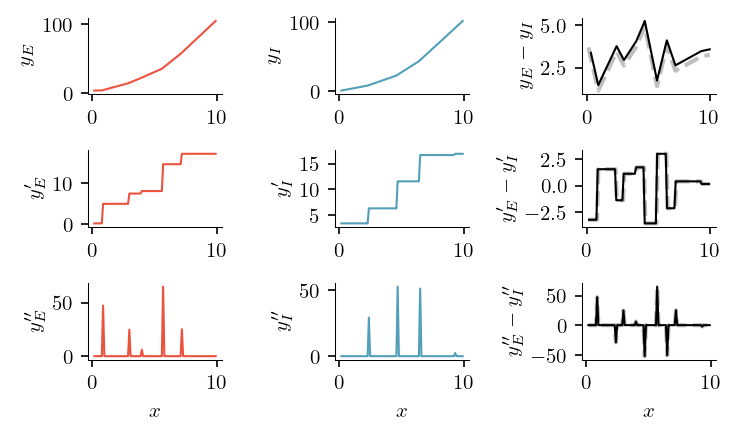

In [7]:
# plot the results
f = plt.figure(figsize=(5,3),dpi=150)
gs = f.add_gridspec(3,3)

ax1a = f.add_subplot(gs[0, 0])
ax2a = f.add_subplot(gs[1, 0])
ax3a = f.add_subplot(gs[2, 0])
ax1b = f.add_subplot(gs[0, 1])
ax2b = f.add_subplot(gs[1, 1])
ax3b = f.add_subplot(gs[2, 1])
ax1c = f.add_subplot(gs[0, 2])
ax2c = f.add_subplot(gs[1, 2])
ax3c = f.add_subplot(gs[2, 2])

ax3a.plot(ddx,C_E_x,c=pu.excitatory_red,linewidth=1)
ax2a.plot(ddx,G_E_x,c=pu.excitatory_red,linewidth=1)
ax1a.plot(ddx,B_E_x,c=pu.excitatory_red,linewidth=1)
ax1a.set_ylabel(r"$y_E$")
ax2a.set_ylabel(r"$y_E'$")
ax3a.set_ylabel(r"$y_E''$")

ax3b.plot(ddx,C_I_x,c=pu.inhibitory_blue,linewidth=1)
ax2b.plot(ddx,G_I_x,c=pu.inhibitory_blue,linewidth=1)
ax1b.plot(ddx,B_I_x,c=pu.inhibitory_blue,linewidth=1)
ax1b.set_ylabel(r"$y_I$")
ax2b.set_ylabel(r"$y_I'$")
ax3b.set_ylabel(r"$y_I''$")

ax3c.plot(ddx,C_pw,c='gray',linestyle='--',linewidth=2,alpha=0.5)
ax3c.plot(ddx,C_E_x-C_I_x,**kws)
ax2c.plot(dx,G_pw,c='gray',linestyle='--',linewidth=2,alpha=0.5)
ax2c.plot(ddx,G_E_x-G_I_x,**kws)
ax1c.plot(x,B_pw,c='gray',linestyle='--',linewidth=2,alpha=0.5)
ax1c.plot(ddx+d_x,B_E_x-B_I_x,**kws)
ax1c.set_ylabel(r"$y_E-y_I$")
ax2c.set_ylabel(r"$y_E'-y_I'$")
ax3c.set_ylabel(r"$y_E''-y_I''$")

ax3a.set_xlabel('$x$')
ax3b.set_xlabel('$x$')
ax3c.set_xlabel('$x$')

sns.despine()
f.tight_layout()


#### Step 4: Construct the full E and I boundaries

In [8]:
# now try to do the full 3d space

# d_x = 0.1
dyE = d_x
xmax = 10
yEmax = 12
xvals = np.linspace(0, xmax, int(xmax / d_x) + 1)[3:]
yEvals = np.linspace(0, yEmax, int(yEmax / dyE) + 1)

# define parameters
g_E_y = 1  # 0.3
g_I_y = 2  # 0.9
b_E_y = 0.0  # 0.25
b_I_y = 0  # -1.3

# define functions
C_E_y = np.zeros_like(yEvals)
C_I_y = np.zeros_like(yEvals)
G_E_y = np.cumsum(dyE*C_E_y) + g_E_y
G_I_y = np.cumsum(dyE*C_I_y) + g_I_y
B_E_y = np.cumsum(dyE*G_E_y) + b_E_y
B_I_y = np.cumsum(dyE*G_I_y) + b_I_y

x_mesh,yE_mesh = np.meshgrid(xvals,yEvals)
B_E_x_mesh, B_E_y_mesh = np.meshgrid(B_E_x,B_E_y)
B_I_x_mesh, B_I_y_mesh = np.meshgrid(B_I_x,B_I_y)

B_E = B_E_x_mesh + B_E_y_mesh
B_I = B_I_x_mesh + B_I_y_mesh

# calculate input-output curves, yE = f_E(x), yI = f_I(x)
Z = np.abs(B_E-B_I)
yE_ids = np.argmin(Z,axis=0)
yE_soln = yEvals[yE_ids]
yI_soln = B_E[yE_ids,np.arange(Z.shape[1])]

X = x_mesh.copy()
YE = yE_mesh.copy()
YI_E = B_E.copy()
YI_I = B_I.copy()

<ipython-input-9-fe93d8ecc06d>:15: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax1.plot_surface(YE.T, X.T, YI_I.T, cmap=pu.blue_cmap,
<ipython-input-9-fe93d8ecc06d>:17: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax1.plot_surface(YE.T, X.T, YI_E.T, cmap=pu.red_cmap,


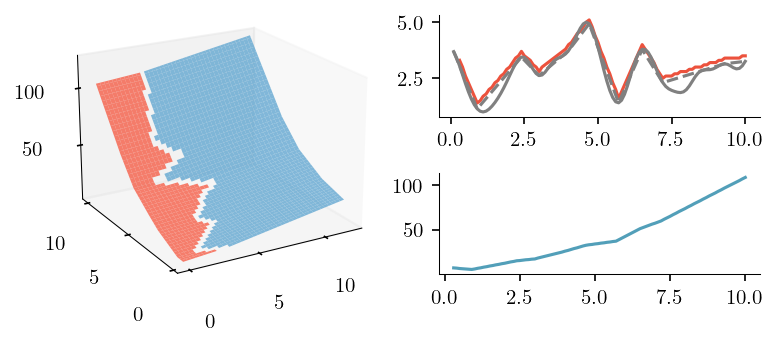

In [9]:
f = plt.figure(figsize=(5,2.25),dpi=150)
gs = f.add_gridspec(2, 2, width_ratios=[1,1])  # , height_ratios=[2.5,0.5,0.5,0.5,0.5])
ax1 = f.add_subplot(gs[:, 0],projection='3d')

ids = np.argmin(np.abs(YI_E-YI_I),0)
yE_soln_x = X[ids,np.arange(X.shape[1])]
yE_soln_yE = YE[ids,np.arange(YE.shape[1])]
yI_soln_x = X[ids,np.arange(X.shape[1])]
yI_soln_yI = YI_I[ids,np.arange(YI_I.shape[1])]

YI_E[YI_E<YI_I] = np.nan
YI_I[YI_I<YI_E] = np.nan

#for i in range(3):
surf = ax1.plot_surface(YE.T, X.T, YI_I.T, cmap=pu.blue_cmap,
                   linewidth=0,antialiased=True,alpha=0.75,vmin=0,vmax=20)
surf = ax1.plot_surface(YE.T, X.T, YI_E.T, cmap=pu.red_cmap,
                   linewidth=0,antialiased=True,alpha=0.75,vmin=0,vmax=20)

ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax1.view_init(elev=20, azim=240)
ax1.dist=8

ax2 = f.add_subplot(gs[0, 1])
ax3 = f.add_subplot(gs[1, 1])
ax2.plot(yE_soln_x,yE_soln_yE,c=pu.excitatory_red)
# ax2.plot(x,B,c='gray',linestyle='-')
ax2.plot(x,B_pw,c='gray',linestyle='--')
ax3.plot(yI_soln_x,yI_soln_yI,c=pu.inhibitory_blue)

sns.despine()
f.tight_layout()

#### Step 5: Simulate the spiking network!

In [10]:

# now convert to spiking and simulate!
dt = 5e-5
leak = 100.
Tend = 0.25
times = np.arange(0, Tend, dt)
nT = len(times)
x = np.linspace(-2.5,10,nT)[None,:]
init_time = 0.05
init_pd = int(init_time/dt)

NE = 50
NI = 50
N = NE + NI
JE = 1
JI = 1
Jx = 1

# get numerical approximations to functions
f_E = RegularGridInterpolator((xvals, yEvals), B_E.T)
f_I = RegularGridInterpolator((xvals, yEvals), B_I.T)

G_E_x_mesh, G_E_y_mesh = np.meshgrid(G_E_x, G_E_y.T)
G_I_x_mesh, G_I_y_mesh = np.meshgrid(G_I_x, G_I_y.T)
dfyE_E = RegularGridInterpolator((xvals, yEvals), G_E_y_mesh.T)
dfx_E = RegularGridInterpolator((xvals, yEvals), G_E_x_mesh.T)
dfyE_I = RegularGridInterpolator((xvals, yEvals), G_I_y_mesh.T)
dfx_I = RegularGridInterpolator((xvals, yEvals), G_I_x_mesh.T)

# define functions:
yE_range = [5]
x_range = [0.31, 10]
(E_EE, E_EI, F_E, T_E, D_E) = scnf.new_interp_fcn_to_nrns(f_E, dfyE_E, dfx_E, yE_range, x_range,
                                                          N=NE, redundancy=1, D_scale=1.0)

yE_range = [5]
x_range = [0.31, 10]
(E_IE, E_II, F_I, T_I, D_I) = scnf.new_interp_fcn_to_nrns(f_I, dfyE_I, dfx_I, yE_range, x_range,
                                                          N=NI, redundancy=1, D_scale=1.0)

# fix decoders
D_E = 0.5*np.ones((1,NE))
D_I = 1.*np.ones((1,NI))

mu_E = 0.01
sigma_vE = 0.01
mu_I = 0.01
sigma_vI = 0.01

(s_E, s_I, V_E, V_I, g_E, g_I) = scnf.run_EI_spiking_net(x,D_E,E_EE,E_EI,F_E,T_E,D_I,E_IE,E_II,F_I,T_I,
                                                                dt=dt,mu_E=mu_E,mu_I=mu_I,
                                                                sigma_vE=sigma_vE,sigma_vI=sigma_vI)
        
# get readouts and spike times
r_E = scnf.exp_filter(s_E,times)
r_I = scnf.exp_filter(s_I,times)
y_E = D_E@r_E
y_I = D_I@r_I

# cut out initial pd
Tend = Tend - init_time
times = times[:-init_pd]
x = x[:, init_pd:]
s_E = s_E[:, init_pd:]
s_I = s_I[:, init_pd:]
y_E = y_E[:, init_pd:]
y_I = y_I[:, init_pd:]

spk_times_E = scnf.get_spike_times(s_E,dt=dt)
spk_times_I = scnf.get_spike_times(s_I,dt=dt)

# latent dynamics over time
x_trace = x[0, :] # np.linspace(0,10,len(times))


<ipython-input-11-6969e33f5f06>:54: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax1.plot_surface(YE.T, X.T, YI_I.T, cmap=pu.blue_cmap,
<ipython-input-11-6969e33f5f06>:56: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax1.plot_surface(YE.T, X.T, YI_E.T, cmap=pu.red_cmap,


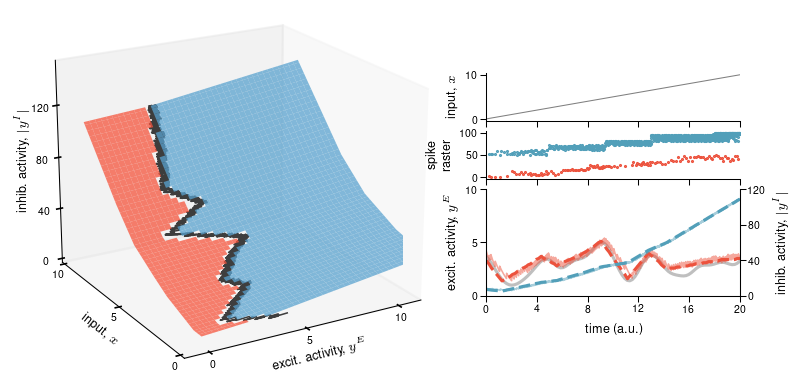

In [11]:
# plot results
f = plt.figure(figsize=(6,3),dpi=150)
gs = f.add_gridspec(6, 2, height_ratios=[1, 1, 1, 1, 1, 1], width_ratios=[1.5, 1])

ax1 = f.add_subplot(gs[:, 0],projection='3d')
ax2 = f.add_subplot(gs[1, 1])
ax3 = f.add_subplot(gs[2, 1])
ax4 = f.add_subplot(gs[3:5, 1])

ax4.plot(np.linspace(0, times[-1], B.shape[0]), B, c='gray', alpha=0.5)

twin = ax4.twinx()
ax2.plot(times,x_trace,'-',c='black',alpha=0.5,linewidth=0.5)
mod_times = np.linspace(0, Tend, yE_soln_yE.shape[0])
ax4.plot(mod_times,yE_soln_yE,'--',c=pu.excitatory_red)
twin.plot(mod_times,yI_soln_yI,'--',c=pu.inhibitory_blue)
h2=ax4.plot(times,y_E[0,:],c=pu.excitatory_red,alpha=0.5,linewidth=0.75)
h2=twin.plot(times,y_I[0,:],c=pu.inhibitory_blue,alpha=0.5,linewidth=0.75)

# spike raster
for i in range(NE):
    ax3.plot(spk_times_E[i],i*np.ones_like(spk_times_E[i]),'.',color=pu.excitatory_red,markersize=1)#cmap[i])
for i in range(NI):
    ax3.plot(spk_times_I[i],NE+i*np.ones_like(spk_times_I[i]),'.',color=pu.inhibitory_blue,markersize=1)#cmap[i])

for ax in [ax2,ax3,ax4]:
    ax.set_xlim([0.0,Tend])
    ax.set_xticks(np.linspace(0.0,Tend,6))
    ax.set_xticklabels([])
    ax.tick_params(axis='both',width=0.5,length=3,pad=1)

ax2.set_yticks([0,10])
ax2.set_yticklabels(['0','10'],fontsize=pu.fs1)
ax3.set_yticks([0,NE,NE+NI])
ax3.set_yticklabels(['0',str(NE),str(NE+NI)],fontsize=pu.fs1)
ax4.set_yticks([0,5,10])
ax4.set_yticklabels(['0','5','10'],fontsize=pu.fs1)
twin.set_yticks([0,40,80,120])
twin.set_yticklabels(['0','40','80','120'],fontsize=pu.fs1)
twin.tick_params(axis='both',width=0.5,length=3,pad=1)

ax4.set_xticklabels(['%.0f'%(100.*x) for x in np.linspace(0.0,Tend,6)],fontsize=pu.fs1)
ax4.set_xlabel('time (a.u.)',fontsize=pu.fs2)

ax2.set_ylabel(r'input, $x$',fontsize=pu.fs2)
ax4.set_ylabel(r'excit. activity, $y^E$',fontsize=pu.fs2)
twin.set_ylabel(r'inhib. activity, $|y^I|$',fontsize=pu.fs2)
ax3.set_ylabel('spike\n raster',fontsize=pu.fs2)
ax4.set_ylim([0,10])
twin.set_ylim([0,120])

# 3d plot
ax1.set_box_aspect((10,10,8.2))
surf = ax1.plot_surface(YE.T, X.T, YI_I.T, cmap=pu.blue_cmap,
                   linewidth=0,antialiased=True,alpha=0.75,vmin=0,vmax=20)
surf = ax1.plot_surface(YE.T, X.T, YI_E.T, cmap=pu.red_cmap,
                   linewidth=0,antialiased=True,alpha=0.75,vmin=0,vmax=20)

ax1.plot(y_E[0,:],x[0,:],y_I[0,:],c='black',alpha=0.75,linewidth=0.75)

ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax1.axes.set_xlim3d(left=-1, right=11) 
ax1.axes.set_ylim3d(bottom=-0.1, top=1.1) 
ax1.axes.set_zlim3d(bottom=0, top=1.2*np.nanmax(YI_I)) 

ax1.set_ylabel(r'input, $x$', fontsize=pu.fs2)
ax1.set_xlabel(r'excit. activity, $y^E$',fontsize=pu.fs2)#,linespacing=1.2)
ax1.xaxis.labelpad=-14
ax1.yaxis.labelpad=-14
ax1.zaxis.labelpad=-12
ax1.zaxis.set_rotate_label(False)
ax1.set_zlabel(r'inhib. activity, $|y^I|$', fontsize=pu.fs2, rotation = 90)
tst=ax1.set_xticks([0,5,10])
tst=ax1.set_yticks([0,5,10])
tst=ax1.set_zticks([0,40,80,120])
tst=ax1.set_xticklabels(['0','5','10'],fontsize=pu.fs1)
tst=ax1.set_yticklabels(['0','5','10'],fontsize=pu.fs1)
tst=ax1.set_zticklabels(['0','40','80','120'],fontsize=pu.fs1)

ax1.tick_params(axis='x', which='major', pad=-6)#, length=50, width=2)
ax1.tick_params(axis='y', which='major', pad=-6)
ax1.tick_params(axis='z', which='major', pad=-4)
ax1.tick_params(axis='both',width=0.5,length=3)#,pad=1)

ax1.view_init(elev=20, azim=240)
ax1.dist=8

sns.despine(ax=ax2)
sns.despine(ax=ax3)
sns.despine(ax=ax4,left=False, right=False)
sns.despine(ax=twin,left=False, right=False)